# Anomaly Detection in Financial Time Series with the LSTM-AE SageMaker Algorithm 

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Anomaly Detection (LSTM-AE) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-up2haipz3j472).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:<...>"

Install the [Python API for FRED](https://github.com/mortada/fredapi).

In [2]:
!pip install fredapi

Set up the SageMaker session and connect to the FRED database.

In [3]:
import io
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred

# FRED API
fred = Fred(api_key_file="api_key.txt")

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Data preparation

Download the data.

In [4]:
dataset = pd.DataFrame({
    "WTI": fred.get_series("DCOILWTICO", observation_start="1987-05-20"),
    "BRENT": fred.get_series("DCOILBRENTEU", observation_start="1987-05-20")
})

In [5]:
dataset.shape

(9550, 2)

In [6]:
dataset.head()

,WTI,BRENT
1987-05-20,19.75,18.63
1987-05-21,19.95,18.45
1987-05-22,19.68,18.55
1987-05-25,NaN,18.60
1987-05-26,19.35,18.63


In [7]:
dataset.tail()

,WTI,BRENT
2023-12-20,73.87,81.10
2023-12-21,73.59,80.73
2023-12-22,73.29,80.23
2023-12-25,NaN,80.23
2023-12-26,75.84,NaN


Calculate the percentage changes.

In [8]:
dataset = dataset.pct_change()

/tmp/ipykernel_12865/277374408.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  dataset = dataset.pct_change()


Fill the missing values with zero.

In [9]:
dataset = dataset.fillna(value=0)

Visulize the data.

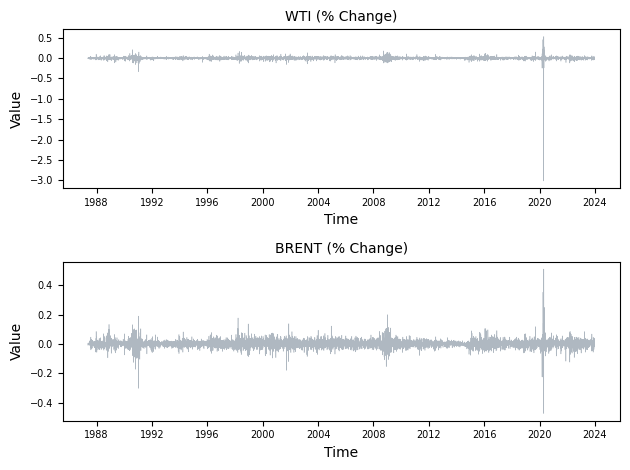

In [10]:
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, sharex=True)
for i in range(dataset.shape[1]):
    axs[i].plot(dataset.iloc[:, i], color="#AFB8C1", lw=0.4)
    axs[i].set_title(f"{dataset.columns[i]} (% Change)", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Split the data.

In [11]:
cutoff = 8350

In [12]:
training_dataset = dataset.iloc[:cutoff]

In [13]:
training_dataset.shape

(8350, 2)

In [14]:
test_dataset = dataset.iloc[cutoff:]

In [15]:
test_dataset.shape

(1200, 2)

Upload the data to S3.

In [16]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="oil_price_train.csv"
)

In [17]:
training_data

's3://sagemaker-eu-west-1-661670223746/oil_price_train.csv'

In [18]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="oil_price_test.csv"
)

In [19]:
test_data

's3://sagemaker-eu-west-1-661670223746/oil_price_test.csv'

### 3. Training

Fit the model to the training set.

In [20]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "sequence-length": 10,
        "sequence-stride": 1,
        "hidden-size": 20,
        "lr": 0.001,
        "batch-size": 128,
        "epochs": 500,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: lstm-ae-v1-4-2024-01-02-15-45-56-455


2024-01-02 15:45:56 Starting - Starting the training job...
2024-01-02 15:46:10 Starting - Preparing the instances for training......
2024-01-02 15:47:19 Downloading - Downloading input data...
2024-01-02 15:47:49 Downloading - Downloading the training image...............
2024-01-02 15:50:05 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-01-02 15:50:31,006 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-01-02 15:50:31,007 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-02 15:50:31,007 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-02 15:50:31,018 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-01-02 15:50:31,020 sagemaker_pytorch_container.training INFO     Invokin

### 4. Inference

Generate the test set reconstructions.

In [21]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: lstm-ae-v1-4-2024-01-02-15-54-42-834


.........

INFO:sagemaker:Creating model with name: lstm-ae-v1-4-2024-01-02-15-54-42-834-2024-01-02-15-55-28-286


INFO:sagemaker:Creating transform job with name: lstm-ae-v1-4-2024-01-02-15-55-29-044


2024-01-02T16:02:48,369 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2024-01-02T16:02:48,369 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2024-01-02T16:02:48,373 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2024-01-02T16:02:48,436 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2024-01-02T16:02:48,541 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.2
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metri

Load the test set reconstructions from S3.

In [22]:
reconstructions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/oil_price_test.csv.out"
)

In [23]:
reconstructions = pd.read_csv(io.StringIO(reconstructions), header=None, dtype=float)

In [24]:
reconstructions.shape

(1200, 3)

In [25]:
reconstructions.head()

,0,1,2
0,1.907602,0.002899,0.004137
1,19.375970,-0.000966,0.000757
2,0.830834,-0.002826,-0.001280
3,0.783775,-0.002655,-0.001191
4,5.608404,-0.001556,-0.000240


In [26]:
reconstructions.tail()

,0,1,2
1195,0.634651,0.006902,0.012374
1196,0.650869,-0.005078,0.000103
1197,0.846772,-0.006380,-0.005355
1198,0.795480,0.000773,-0.002781
1199,0.866907,0.036642,0.000922


Visualize the reconstructions.

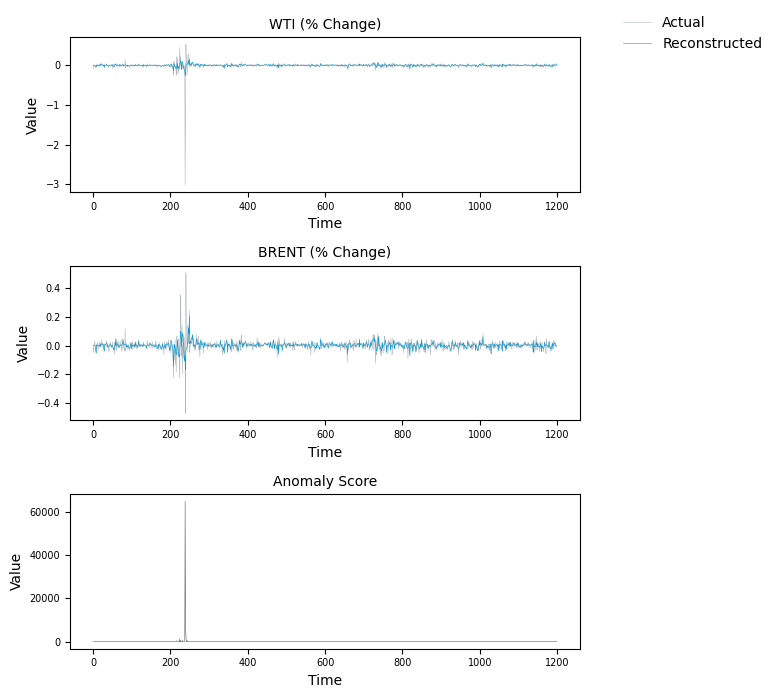

In [27]:
fig, axs = plt.subplots(nrows=test_dataset.shape[1] + 1, ncols=1, sharex=True, figsize=(6, 7))
for i in range(test_dataset.shape[1]):
    axs[i].plot(test_dataset.iloc[:, i].values, color="#AFB8C1", lw=0.4, label="Actual" if i == 0 else None)
    axs[i].plot(reconstructions.iloc[:, i + 1].values, color="#009ad3", lw=0.4, label="Reconstructed" if i == 0 else None)
    axs[i].set_title(f"{test_dataset.columns[i]} (% Change)", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
i += 1
axs[i].set_title("Anomaly Score", size=10)
axs[i].plot(reconstructions.iloc[:, 0], color="#57606a", lw=0.4)
axs[i].set(xlabel="Time", ylabel="Value")
axs[i].xaxis.set_tick_params(labelbottom=True)
axs[i].tick_params(axis="both", which="major", labelsize=7)
axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1.3, 1, 0, 0), frameon=False)
fig.tight_layout()
fig.show()

Delete the model.

In [28]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: lstm-ae-v1-4-2024-01-02-15-54-42-834-2024-01-02-15-55-28-286
